In [1]:
# install packages
! pip install pandas==1.1.5
! pip install xgboost==1.4.2
! pip install numpy==1.19.5

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, average_precision_score

import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.getcwd()

# Check if running in Colab
try:
  from google.colab import drive
  IN_COLAB=True
  print("Running in Colab")
  # Mount Google Drive 
  drive.mount('/content/drive')
  # Change directory
  path = "/content/drive/My \Drive/BitterMatch"
  %cd /content/drive/My \Drive/BitterMatch
except:
  IN_COLAB=False
  print("Running locally")

Running in Colab
Mounted at /content/drive
/content/drive/My Drive/BitterMatch


In [4]:
from similarity import *
from preprocessing import *

## 1. Load data and pre-process to obtain inputs

To train the model the following input is required:
* $A \in \mathbb{R}^{L \times R}$ - An association matrix between $L$ ligands and $R$ receptors
* $X^{\text{Rec}}$ - A matrix of receptor features (each row corresponding to a receptor)
* $X^{\text{Lig}}$ - A matrix of ligand features (each row corresponding to a ligand)
* $S^{\text{Lig}}_1, \dots, S^{\text{Lig}}_m$ - Precomputed similarity matrices between ligands 

Here we provide helper functions to obtain these inputs from the formats listed in the paper. If the inputs are obtained from a different source the first section should be skipped or replaced.

Load and prepare $A, X^{\text{Rec}}, X^{\text{Lig}}$

In [6]:
A = load_A('Data/bitterdb_associations.csv')

In [7]:
# remove orphan receptors from association matrix
orphan_receptors = A.columns[np.sum(A, axis=0)==0]
A = A[A.columns[~np.isin(A.columns, orphan_receptors)]]

In [9]:
X_Rec = load_X_Rec('Data/receptor_features.csv')

# remove orphan receptors from receptor features matrix
X_Rec = X_Rec[~np.isin(X_Rec.column_label, orphan_receptors)]

In [10]:
X_Lig = load_X_Lig('Data/ligand_features.csv')

Load and prepare $S^{\text{Lig}}_1, S^{\text{Lig}}_2$

In [12]:
Lig_linear_sim = read_ligand_similarity('Data/Ligand_Linear_Similarity.csv') 
Lig_mol2d_sim = read_ligand_similarity('Data/Ligand_mol2D_Similarity.csv')

In [13]:
# restrict ligand similarities only to those in A
Lig_linear_sim = Lig_linear_sim.iloc[np.isin(Lig_linear_sim.index, A.index), np.isin(Lig_linear_sim.columns, A.index)]
Lig_mol2d_sim = Lig_mol2d_sim.iloc[np.isin(Lig_mol2d_sim.index, A.index), np.isin(Lig_mol2d_sim.columns, A.index)]

## 2. Prepare feature matrix

In [14]:
# create data frame of all pairs of ligand-receptor
pairs = pd.melt(A.assign(ligand=A.index), id_vars='ligand', var_name='receptor', value_name='association')
# shuffle
pairs = pairs.sample(frac=1).reset_index(drop=True)

### 2.1 Determine train-test split and mask test associations from $A$

In [15]:
def train_test_split(pairs_df, p=0.8):
    
    all_ligands = np.unique(pairs_df.ligand)
    train_ligands = np.random.choice(all_ligands, int(p*len(all_ligands)), replace=False)
    pairs_df['test'] = np.logical_not(np.isin(pairs_df.ligand, train_ligands))

    return pairs_df

In [16]:
pairs = train_test_split(pairs)

In [17]:
# mask test values in association matrix - mask all associations of given ligand
masked_A = A.mask(pairs.pivot(index='ligand', columns='receptor', values='test').astype('bool'))

### 2.2 Add chemical properties of ligands and receptors

In [18]:
# cross join ligand and receptor data
features_df = pd.merge(X_Lig.rename(columns=lambda r: 'Lig_%s' % r).assign(key_=1),
                       X_Rec.rename(columns=lambda c: 'Rec_%s' % c).assign(key_=1),
                       on='key_').drop('key_', 1)
features_df = features_df.rename(columns={'Lig_cid': 'ligand', 'Rec_column_label': 'receptor'})
#features_df.drop('Lig_Unnamed: 0', inplace=True, axis=1)

# add a feature indicating whether the receptor is human
features_df['is_human_receptor'] = features_df.receptor<2000

# add association (ground truth) and train/test split
features_df = features_df.merge(pairs, how='outer', on=['ligand', 'receptor'])

# shuffle
features_df = features_df.sample(frac=1)

### 2.3 Similarities

#### 2.3.1 Extract similarity based metrics
$W_{l1}$ -  average similarity of the ligand $l$ to ligands $l'$ that associate with a receptor $r$ <br />
$W_{l0}$ - average similarity of the ligand $l$ to ligands $l'$ that do not associate with a receptor $r$  <br /> 
$M_{l1}$  - similarity between the ligand $l$  and the most similar ligand that associates with a receptor  r <br />
$M_{l0}$  - similarity between the ligand $l$  and the most similar ligand that does not associate with a receptor  r <br />

In [19]:
sim_metrics_dict = {'Lig_linear_sim':       (Lig_linear_sim,   0),
                    'Lig_mol2d_sim':        (Lig_mol2d_sim,    0)}

In [20]:
test_ligands = np.unique(pairs.ligand[pairs.test==True])

In [21]:
# add similarity based features to the features data frame
for prefix, (sim_df, axis) in sim_metrics_dict.items():
    sim_metrics_df = sim_metrics(sim_df, masked_A, axis).rename(columns=lambda col: '%s_%s' % (prefix, col))
    features_df = features_df.merge(sim_metrics_df, how='left', on=['ligand', 'receptor'])

### 2.4 Create $X^{\text{Tr}}, X^{\text{Te}}, Y^{\text{Tr}}, Y^{\text{Te}}$ matrices  

In [22]:
X_train = features_df[(features_df.test == False) & (features_df.association.isna() == False)].drop(['ligand', 'receptor', 'association', 'test'], axis=1)

results_df = features_df[(features_df.test == True) & (features_df.association.isna() == False)]
X_test = results_df.drop(['ligand', 'receptor', 'association', 'test'], axis=1)
results_df = results_df[['ligand', 'receptor', 'association']]

Y_train = features_df[(features_df.test == False) & (features_df.association.isna() == False)].association.values
Y_test = features_df[(features_df.test == True) & (features_df.association.isna() == False)].association.values

## 3. Train BitterMatch

In [23]:
# Full model (sub-model no. 4)
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic',  booster = 'gbtree',  n_jobs = -1, seed = 1,  subsample =  0.7, scale_pos_weight = 1,  min_child_weight = 0.45, max_depth =  4, learning_rate = 1e-3, gamma =  2.0, colsample_bytree = 0.3, colsample_bylevel = 1.0, n_estimators = 1000, silent = None, verbosity = 0)
model = xgb_clf.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)

In [24]:
results_df['BitterMatch'] = Y_pred[:,1]

In [25]:
# # Save a model
# with open('trained_model_for_new_ligands.pkl', 'wb') as f:
#     pickle.dump(model, f)

## 4. Baseline Models

### 4.1 Prior

In [26]:
prior = np.sum(masked_A, axis=0)/np.sum(~np.isnan(masked_A),axis=0)

In [27]:
results_df = results_df.join(prior.rename('prior'), on=["receptor"], how="left")

### 4.2 Nearest Neighbor


In [28]:
S = Lig_linear_sim

In [29]:
sim_to_train = S.iloc[np.isin(S.index, test_ligands), ~np.isin(S.columns, test_ligands)]

In [30]:
results_df['NN'] = np.zeros(results_df.shape[0])

In [31]:
for l in test_ligands:
    v = sim_to_train[sim_to_train.index==l]
    neigh_ord = v.columns.values[np.argsort(-v.values)][0]
    l_pairs = results_df[results_df.ligand==l]
    l_A = masked_A[l_pairs.receptor]
    for r in l_A.columns:
        ordered_A = l_A[r].reindex(neigh_ord) #l_A[r][neigh_ord]
        first_known = ordered_A[ordered_A.index[np.where(~np.isnan(ordered_A))[0][0]]]
        if first_known==1:
            results_df.NN[(results_df.ligand==l) & (results_df.receptor==r)]=1

## 5. Results

In [33]:
# Association probabilities
Y_pred = Y_pred[:,1]
prior_pred = results_df.prior
NN_pred = results_df.NN

In [34]:
# Recall-precision curves
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)
prior_precision, prior_recall, prior_thresholds = precision_recall_curve(Y_test, prior_pred)
NN_precision, NN_recall, NN_thresholds = precision_recall_curve(Y_test, NN_pred)

In [35]:
# Average precision
avg_precision = average_precision_score(Y_test, Y_pred)
prior_avg_precision = average_precision_score(Y_test, prior_pred)
NN_avg_precision = average_precision_score(Y_test, NN_pred)

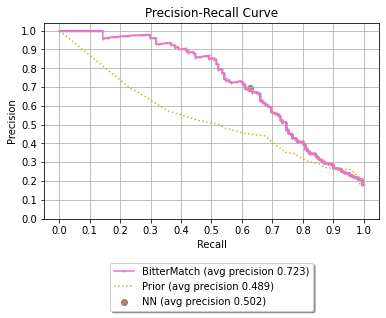

In [42]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(recall, precision, label = 'BitterMatch (avg precision {})'.format(np.round(avg_precision,3)), color = 'C6', marker='.', markersize=2)
ax.plot(prior_recall, prior_precision,  ':', color='C8', label = 'Prior (avg precision {})'.format(np.round(prior_avg_precision,3)))
ax.scatter(NN_recall[1], NN_precision[1],   label = 'NN (avg precision {})'.format(np.round(NN_avg_precision,3)), color='C5', alpha=0.7)
ax.grid()

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=1)

plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1));